# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling
import sqlite3 as sqlite
import imblearn
from imblearn.over_sampling import SMOTENC
from imblearn.metrics import sensitivity_score, specificity_score
from collections import Counter
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, plot_roc_curve

# Load Dataset

In [2]:
df = pd.read_csv('ICU.csv')

In [3]:
df.head()

,Unnamed: 0,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
0,1,4,0,87,3,1,1,80,96,1
1,2,8,1,27,1,1,1,142,88,1
2,3,12,1,59,2,0,0,112,80,1
3,4,14,1,77,3,0,0,100,70,0
4,5,27,0,76,3,1,1,128,90,1


In [4]:
df.shape

(200, 10)

From the above output, the dataset is rather small with only 200 observations and 10 features

In [5]:
df.columns

Index(['Unnamed: 0', 'ID', 'Survive', 'Age', 'AgeGroup', 'Sex', 'Infection',
       'SysBP', 'Pulse', 'Emergency'],
      dtype='object')

## Convert data to a tidy format

In [6]:
# Check for missing values
df.isna().sum()

Unnamed: 0    0
ID            0
Survive       0
Age           0
AgeGroup      0
Sex           0
Infection     0
SysBP         0
Pulse         0
Emergency     0
dtype: int64

From the above output, the dataset does not contain any missing values

In [7]:
# Check for duplicate observations
df.duplicated().sum()

0

From the above output, the dataset does not contain any duplicate observations

In [8]:
# Column names: Remove white spaces and convert to lower case
df.columns= df.columns.str.strip().str.lower()

# Check that column names have been converted to lowercase
df.columns

Index(['unnamed: 0', 'id', 'survive', 'age', 'agegroup', 'sex', 'infection',
       'sysbp', 'pulse', 'emergency'],
      dtype='object')

In [9]:
# Check number of observations in respective target classes
df.survive.value_counts()

1    160
0     40
Name: survive, dtype: int64

In the above output, `0` denotes `Died` and `1` denotes `Survived` for the respective target classes.

By default, `1`, i.e. `Survived` is taken to be the positive class. However, we want `Died` to be the positive class when calculating evaluation metrics such as sensitivity. Hence, the labels of the target classes will be exchanged such that `0` denotes `Survived` and `1` denotes `Died`.

In [10]:
df['survive'] = df['survive'].replace([0, 1], [1, 0])

In [11]:
# Check that labels for target classes have been swapped successfully
df.survive.value_counts()

0    160
1     40
Name: survive, dtype: int64

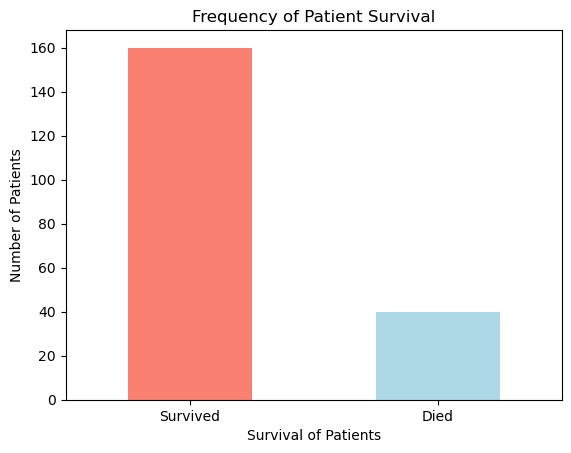

In [12]:
# Plot respective counts of target classes
df.survive.value_counts().plot(kind="bar", color=["salmon", "lightblue"])
plt.title('Frequency of Patient Survival')
plt.xlabel('Survival of Patients')
plt.ylabel('Number of Patients')
plt.xticks((0, 1), ('Survived', 'Died'))
plt.xticks(rotation=0);

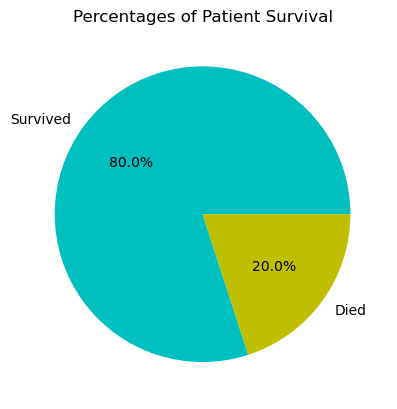

In [14]:
# Plot pie chart to show percentages of respective target classes
plt.pie(df.survive.value_counts(), labels= ['Survived', 'Died'], colors = ['c', 'y'], autopct='%1.1f%%')
plt.title('Percentages of Patient Survival')
plt.show()

The distribution of target classes is unbalanced with only 20% of total observations belonging to `Died`. Such data imbalance would cause the models to be biased towards predicting the majority class `Survived`. This issue is addressed using **SMOTE-NC** in a later section.

In [15]:
# Remove unnecessary columns
df.drop(columns=['unnamed: 0', 'id', 'agegroup'], inplace=True)

The unique values of all variables are checked to ensure that there are no invalid or problematic values (eg. inifinite value, negative values for non-negative numerical columns such as `age`)

In [24]:
for col_name in df.columns:
    print(f"Unique Values for {col_name}: {df[col_name].unique()}\n")

Unique Values for survive: [1 0]

Unique Values for age: [87 27 59 77 76 54 69 63 30 35 78 70 55 48 66 61 52 72 60 16 62 19 74 68
 67 53 92 51 64 88 23 73 57 75 91 41 18 45 80 82 40 47 32 49 46 20 71 79
 65 50 34 84 83 24 85 36 58 25 21 31 28 17 89 42]

Unique Values for sex: [1 0]

Unique Values for infection: [1 0]

Unique Values for sysbp: [ 80 142 112 100 128 110 104 144 108 130 138 188 162 160 174 206 150 140
  48 132 120 114 180 200 170 158  62 148 124 134  64 168 141 146 126 135
  86  68 116  90 190 156  36 154 164 139  66  92 122 208  70 118 212 136
 224 152 131  78 204  56  91 169 256]

Unique Values for pulse: [ 96  88  80  70  90 103 154 132  66 110  60  86 106 100  99  71 116  39
 128  75 111 120  76  98  92 145  64 124 136 125  89 122  95 140  58  81
 112  84 114 170  85 153  83 107 121  94  74 131 118 104  72 108  48  67
  65  44 162  68  46  87 126  91  52 138 119 115 135 105 150 144 143 192
 160  59  62 109  78  79  55  73 137]

Unique Values for emergency: [1 0]



From the above output, there are no problematic values in the respective variables.

In [25]:
# Convert categorical variables to dummies
df = pd.get_dummies(df, columns=['sex', 'infection', 'emergency'], drop_first=True)

In [27]:
df.head()

,survive,age,sysbp,pulse,sex_1,infection_1,emergency_1
0,1,87,80,96,1,1,1
1,0,27,142,88,1,1,1
2,0,59,112,80,0,0,1
3,0,77,100,70,0,0,0
4,1,76,128,90,1,1,1


In [28]:
# Rename columns for categorical variables
df.rename(columns={'sex_1': 'sex', 'infection_1': 'infection', 'emergency_1': 'emergency'}, inplace=True)

In [29]:
# Summary statistics of every column
df.describe()

,survive,age,sysbp,pulse,sex,infection,emergency
count,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000
mean,0.200000,57.545000,132.280000,98.92500,0.380000,0.420000,0.735000
std,0.401004,20.054648,32.952099,26.82962,0.486604,0.494797,0.442441
min,0.000000,16.000000,36.000000,39.00000,0.000000,0.000000,0.000000
25%,0.000000,46.750000,110.000000,80.00000,0.000000,0.000000,0.000000
50%,0.000000,63.000000,130.000000,96.00000,0.000000,0.000000,1.000000
75%,0.000000,72.000000,150.000000,118.25000,1.000000,1.000000,1.000000
max,1.000000,92.000000,256.000000,192.00000,1.000000,1.000000,1.000000


In [30]:
# Mean of numerical variables for each target class
df[['survive', 'age', 'sysbp', 'pulse']].groupby('survive').mean()

,age,sysbp,pulse
survive,,,
0,55.650,135.64375,98.500
1,65.125,118.82500,100.625


In [31]:
# Show overview of data
ydata_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Export to normalized table in an SQLite3 database

In [32]:
# Create / Connect to a SQLite3 database
conn = sqlite.connect('icu.db')

In [33]:
# Load data file to SQLite 
df.to_sql('icu_patients', conn, if_exists='replace', index=False)

200

# Exploratory Data Analysis

In [34]:
# Execute SQL query to import entire dataframe
Select_All_Data_Query = "SELECT * FROM icu_patients"
Select_All_Data_Results = conn.execute(Select_All_Data_Query)
Select_All_Data_Results_List = list(Select_All_Data_Results.fetchall())

In [35]:
# Get column names
cursor = conn.cursor()
cursor.execute("PRAGMA table_info(icu_patients)")
columns_df = [row[1] for row in cursor.fetchall()]

In [36]:
# Check column names
columns_df

['survive', 'age', 'sysbp', 'pulse', 'sex', 'infection', 'emergency']

In [37]:
# Convert to dataframe with column names
df = pd.DataFrame(Select_All_Data_Results_List, columns=columns_df)
df.head()

,survive,age,sysbp,pulse,sex,infection,emergency
0,1,87,80,96,1,1,1
1,0,27,142,88,1,1,1
2,0,59,112,80,0,0,1
3,0,77,100,70,0,0,0
4,1,76,128,90,1,1,1


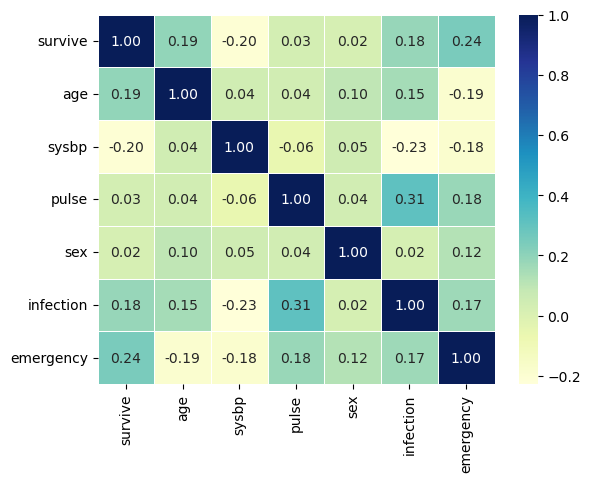

In [38]:
# Find correlation between predictor variables
corr_matrix = df.corr()
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

As shown in the above correlation plot, the correlation between different predictors is generally low. Hence, we choose not to perform feature selection or other associated techniques like PCA.

For the remaining SQL queries in this section, `pd.read_sql` is used to obtain a dataframe directly for data visualization. 

## Data Visualization for Categorical Variables

### Gender

In [39]:
# Extract count of respective genders
gender_summary = pd.read_sql('SELECT sex, COUNT(sex) AS gender_count FROM icu_patients GROUP BY sex', conn)
gender_summary = gender_summary.set_index('sex').rename(index={0: 'Male', 1: 'Female'}).rename_axis(None)
gender_summary

,gender_count
Male,124
Female,76


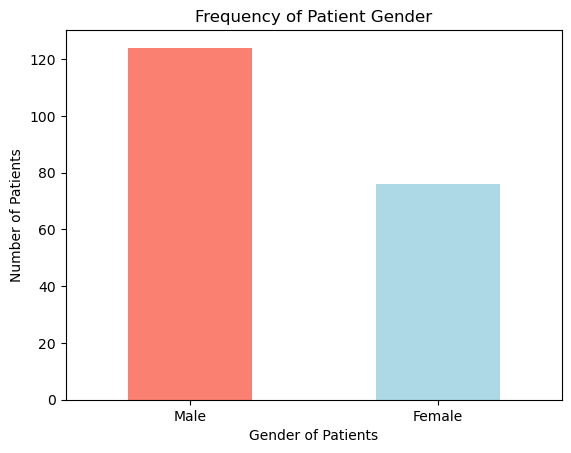

In [40]:
# Plot bar chart to show count of respective genders
gender_summary.gender_count.plot(kind="bar", color=["salmon", "lightblue"])
plt.title('Frequency of Patient Gender')
plt.xlabel('Gender of Patients')
plt.ylabel('Number of Patients')
plt.xticks((0, 1), ('Male', 'Female'))
plt.xticks(rotation=0);

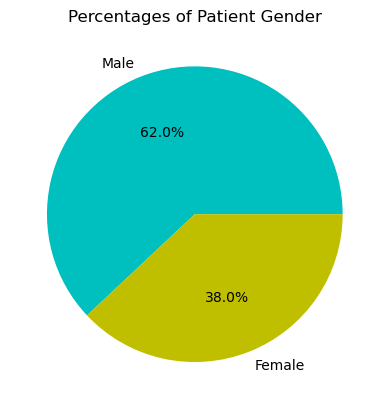

In [41]:
# Plot pie chart to show percentages of respective genders
plt.pie(gender_summary.gender_count, labels= gender_summary.index, colors = ['c', 'y'], autopct='%1.1f%%')
plt.title('Percentages of Patient Gender')
plt.show()

The distribution of `gender` is not very balanced for this dataset, with only 38% `Female` compared to 62% `Male`. 

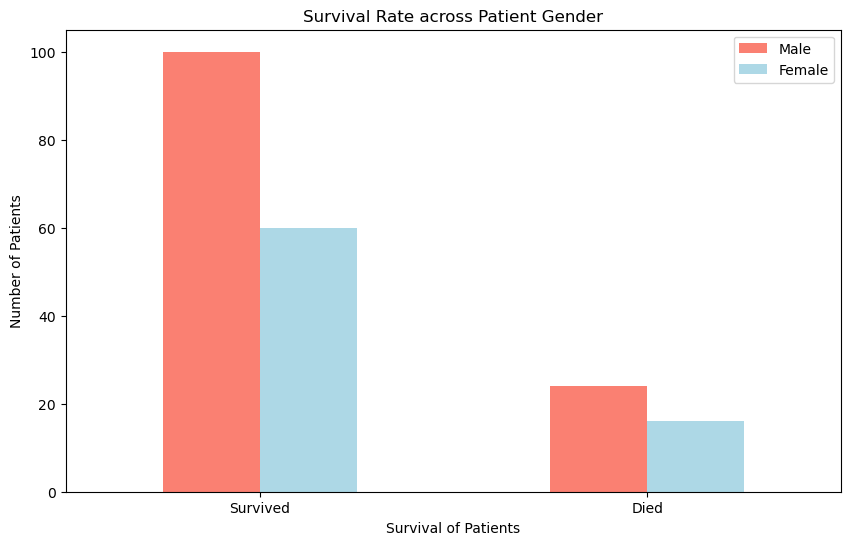

In [43]:
# Gender distribution for each target class
pd.crosstab(df.survive, df.sex).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue"])
plt.title("Survival Rate across Patient Gender")
plt.xlabel("Survival of Patients")
plt.ylabel("Number of Patients")
plt.legend(["Male", "Female"])
plt.xticks((0, 1), ('Survived', 'Died'))
plt.xticks(rotation=0); 

For the `Died` target class, the distribution of patient gender is almost balanced even though the entire dataset contains only 38% `Female`.

### Infection

In [44]:
# Extract count of respective infection rates
infection_summary = pd.read_sql("""SELECT infection, COUNT(infection) AS infection_count 
                                FROM icu_patients GROUP BY infection""", conn)

infection_summary = infection_summary.set_index('infection').rename(
    index={0: 'Not Infected', 1: 'Infected'}).rename_axis(None)

infection_summary

,infection_count
Not Infected,116
Infected,84


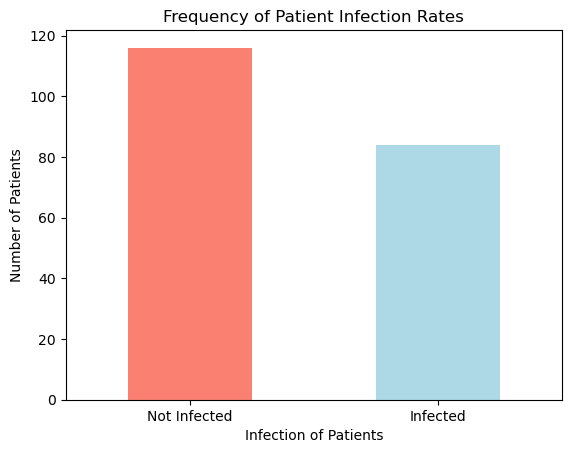

In [45]:
# Plot bar chart to show count of respective infection rates
infection_summary.infection_count.plot(kind="bar", color=["salmon", "lightblue"])
plt.title('Frequency of Patient Infection Rates')
plt.xlabel('Infection of Patients')
plt.ylabel('Number of Patients')
plt.xticks((0, 1), ('Not Infected', 'Infected'))
plt.xticks(rotation=0);

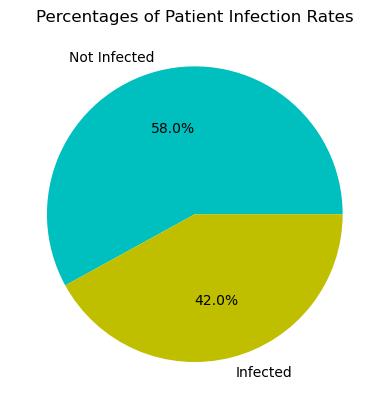

In [46]:
# Plot pie chart to show percentages of respective infection rates
plt.pie(infection_summary.infection_count, labels= infection_summary.index, colors = ['c', 'y'], autopct='%1.1f%%')
plt.title('Percentages of Patient Infection Rates')
plt.show()

The distribution of `infection` is slightly imbalanced for this dataset, with only 42% `Infected` compared to 58% `Not Infected`.

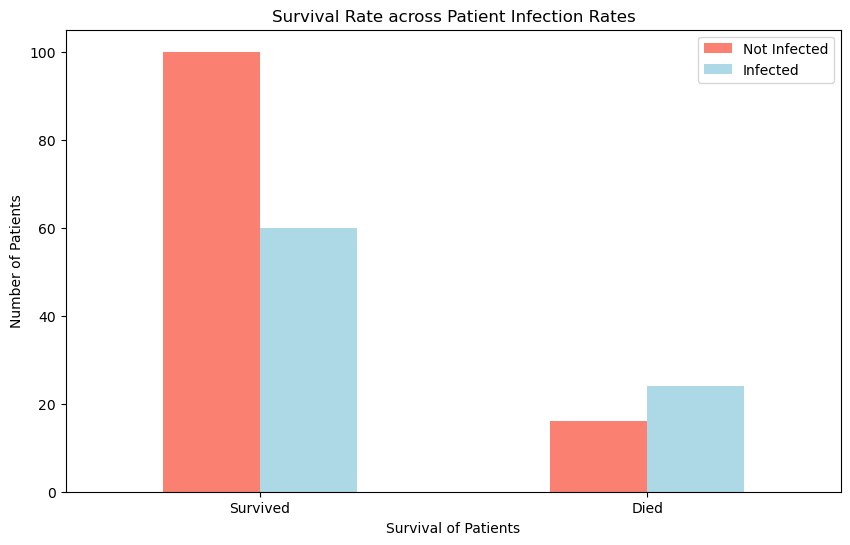

In [47]:
# Infection rate distribution for each target class
pd.crosstab(df.survive, df.infection).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue"])
plt.title("Survival Rate across Patient Infection Rates")
plt.xlabel("Survival of Patients")
plt.ylabel("Number of Patients")
plt.legend(["Not Infected", "Infected"])
plt.xticks((0, 1), ('Survived', 'Died'))
plt.xticks(rotation=0); 

Although there is only 42% `Infected` in the entire dataset, the `Died` target class contains a higher proportion of `Infected` than `Not Infected`, which possibly suggests that `Infection` is an important predictor of patient survival. Among the `Not Infected` patients, only a very small proportion belong to the `Died` target class. This suggests that being `Not Infected` means a very high likelihood of patient survival.

### Emergency

In [48]:
# Extract count of respective emergency rates
emergency_summary = pd.read_sql("""SELECT emergency, COUNT(emergency) AS emergency_count 
                                FROM icu_patients GROUP BY emergency""", conn)

emergency_summary = emergency_summary.set_index('emergency').rename(
    index={0: 'No Emergency', 1: 'Emergency'}).rename_axis(None)

emergency_summary

,emergency_count
No Emergency,53
Emergency,147


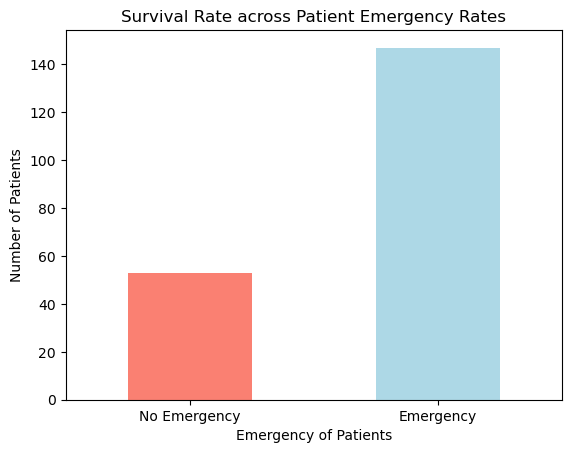

In [50]:
# Plot bar chart to show count of respective emergency rates
emergency_summary.emergency_count.plot(kind="bar", color=["salmon", "lightblue"])
plt.title("Survival Rate across Patient Emergency Rates")
plt.xlabel('Emergency of Patients')
plt.ylabel('Number of Patients')
plt.xticks((0, 1), ('No Emergency', 'Emergency'))
plt.xticks(rotation=0);

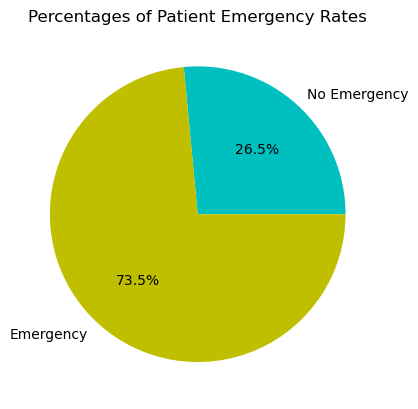

In [51]:
# Plot pie chart to show percentages of respective emergency rates
plt.pie(emergency_summary.emergency_count, labels= emergency_summary.index, colors = ['c', 'y'], autopct='%1.1f%%')
plt.title('Percentages of Patient Emergency Rates')
plt.show()

The distribution of `emergency` is very imbalanced for this dataset, with only 26.5% `No Emergency` compared to 73.5% `Emergency`.

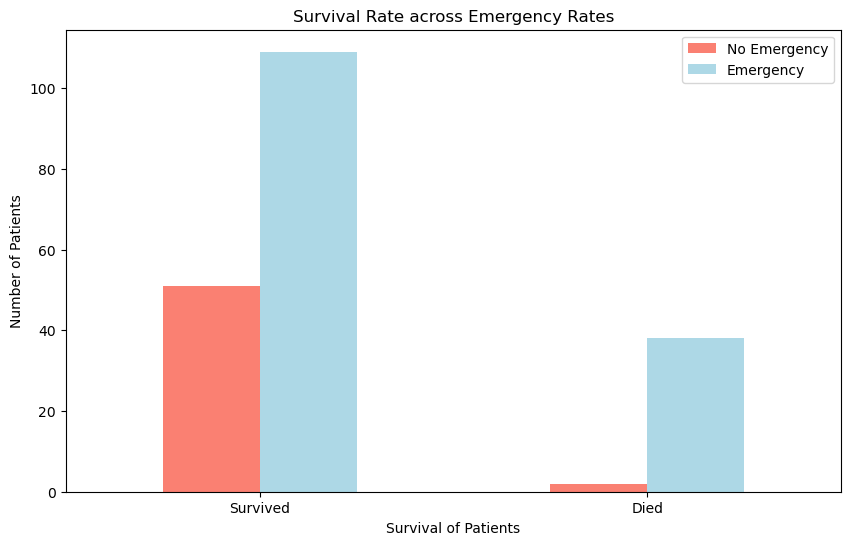

In [52]:
# Emergency rate distribution for each target class
pd.crosstab(df.survive, df.emergency).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue"])
plt.title("Survival Rate across Emergency Rates")
plt.xlabel("Survival of Patients")
plt.ylabel("Number of Patients")
plt.legend(["No Emergency", "Emergency"])
plt.xticks((0, 1), ('Survived', 'Died'))
plt.xticks(rotation=0); 

Among the `No Emergency` patients, only an extremely small number of them belong to the `Died` target class. This suggests that patients with `No Emergency` have a very high likelihood of survival.

## Data Visualization for Numerical Variables

### Summary Statistics across all numeric variables (Maximum, Minimum, Average)

In [53]:
numeric_summary = pd.read_sql_query("""SELECT survive, MAX(age) AS Maximum_Age,  MIN(age) AS Minimum_Age, 
                               AVG(age) AS Average_Age, MAX(pulse) AS Maximum_Pulse, MIN(pulse) AS Minimum_Pulse,
                               AVG(pulse) AS Average_Pulse, MAX(sysbp) AS Maximum_SysBP, MIN(sysbp) AS Minimum_SysBP,
                               AVG(sysbp) AS Average_SysBP FROM icu_patients GROUP BY survive""", conn)
numeric_summary.set_index('survive').rename(index={0: 'Survived', 1: 'Died'}).rename_axis(None)

,Maximum_Age,Minimum_Age,Average_Age,Maximum_Pulse,Minimum_Pulse,Average_Pulse,Maximum_SysBP,Minimum_SysBP,Average_SysBP
Survived,91,16,55.650,192,39,98.500,224,48,135.64375
Died,92,19,65.125,160,55,100.625,256,36,118.82500


While the `Minimum_Age` and `Maximum_Age` are very similar across both target classes, the `Average_Age` is considerably higher for `Died` than for `Survived`. This suggests that patients who did not survive are generally older. The `Average_Pulse` for `Died` and `Survived` are almost the same. Based on `Average_SysBP`, patients in `Survived` generally have higher `sysbp` than patients in `Died`.

### Scatterplot of `pulse` against `age` classified by target variable `survive`

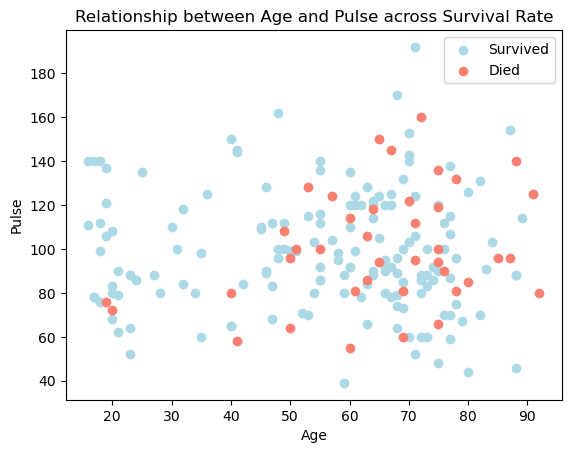

In [54]:
df_survived = pd.read_sql_query("""SELECT age, pulse, sysbp FROM icu_patients WHERE survive == 0""", conn) 
df_died = pd.read_sql_query("""SELECT age, pulse, sysbp FROM icu_patients WHERE survive == 1""", conn) 

plt.scatter(df_survived.age, df_survived.pulse, c="lightblue")
plt.scatter(df_died.age, df_died.pulse, c="salmon")

plt.title("Relationship between Age and Pulse across Survival Rate")
plt.xlabel("Age")
plt.ylabel("Pulse")
plt.legend(["Survived", "Died"])
plt.show()

Among the 40 patients in `Died`, only 4-5 of them belong to smaller age ranges < 50. This suggests that younger patients have a very high likelihood of survival. The distribution of points for both target classes is quite random in the above scatterplot. There seems to be no obvious relationship between `age` and `pulse`.

### Scatterplot of  `sysbp` against `age` classified by target variable `survive`

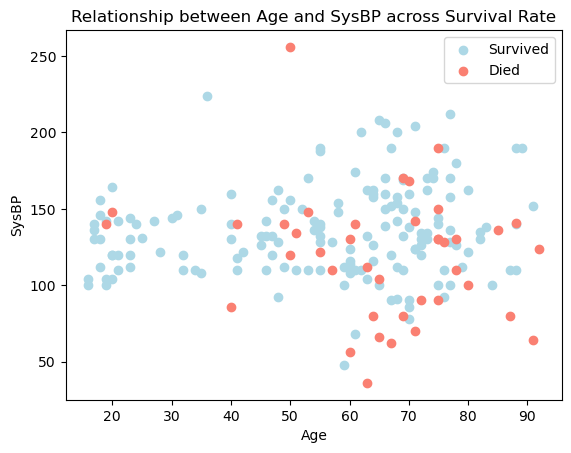

In [55]:
plt.scatter(df_survived.age, df_survived.sysbp, c="lightblue")
plt.scatter(df_died.age, df_died.sysbp, c="salmon")

plt.title("Relationship between Age and SysBP across Survival Rate")
plt.xlabel("Age")
plt.ylabel("SysBP")
plt.legend(["Survived", "Died"])
plt.show()

From the above scatterplot, the overall variance of `sysbp` increases with `age`, as shown from the points being more spread out in larger age ranges. 

### Scatterplot of  `sysbp` against `pulse` classified by target variable `survive`

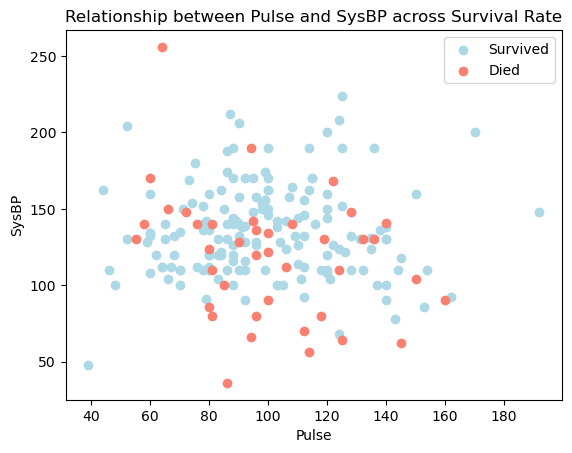

In [56]:
plt.scatter(df_survived.pulse, df_survived.sysbp, c="lightblue")
plt.scatter(df_died.pulse, df_died.sysbp, c="salmon")

plt.title("Relationship between Pulse and SysBP across Survival Rate")
plt.xlabel("Pulse")
plt.ylabel("SysBP")
plt.legend(["Survived", "Died"])
plt.show()

The above scatterplot shows the majority of points being concentrated together with a small number of points lying considerably far away. The overall distribution of points appears to be quite random for both target classes. There seems to be no obvious relationship between `pulse` and `sysbp`.

### Explore the range and distribution of numeric variables

<AxesSubplot:>

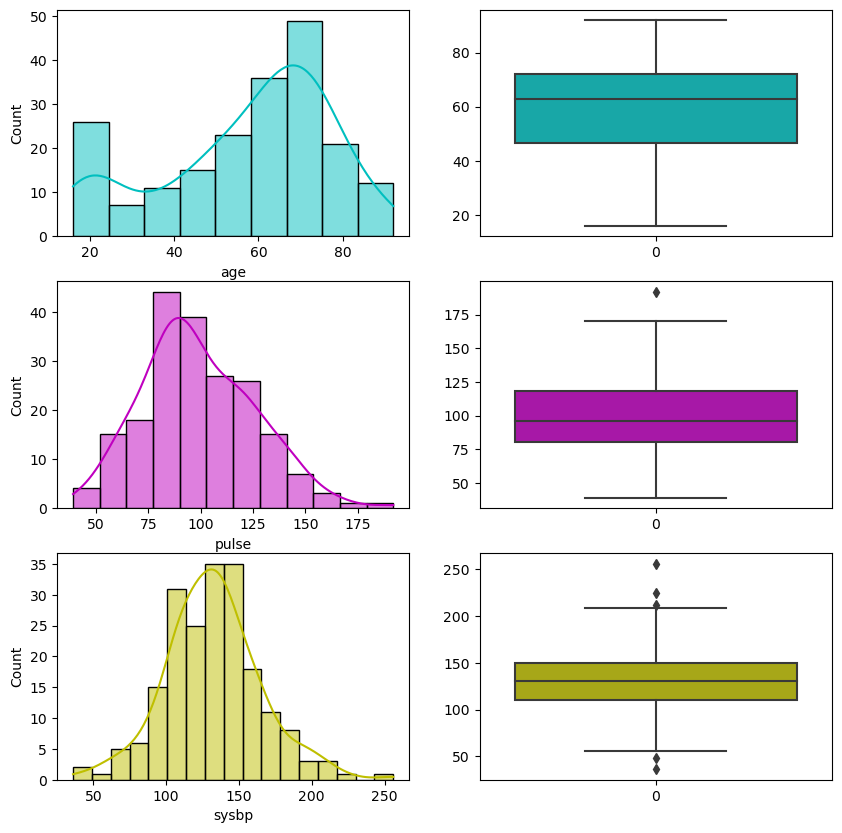

In [57]:
# Histograms and Boxplots of individual numeric variables
fig, ax = plt.subplots(3, 2, figsize = (10, 10))
sns.histplot(df['age'], ax=ax[0, 0], kde=True, color='c')
sns.boxplot(df['age'], ax=ax[0, 1], color='c')
sns.histplot(df['pulse'], ax=ax[1, 0], kde=True, color='m')
sns.boxplot(df['pulse'], ax=ax[1, 1], color='m')
sns.histplot(df['sysbp'], ax=ax[2, 0], kde=True, color='y')
sns.boxplot(df['sysbp'], ax=ax[2, 1], color='y')

From the above histograms, the distribution of `age` is slightly left-skewed and the distribution for `pulse` is slightly right-skewed. The distribution of `sysbp` is more or less symmetrical. The boxplots show 1 outlier for `pulse` and 5 outliers for `sysbp`. There are no outliers for `age`.

In [58]:
# Skewness and Kurtosis of individual numeric variables
numeric_df = df[['age', 'pulse', 'sysbp']]
skew_var = numeric_df.apply(lambda col: skew(col))
kurtosis_var = numeric_df.apply(lambda col: kurtosis(col))
pd.concat([skew_var, kurtosis_var], axis=1).set_axis(['Skew', 'Kurtosis'], axis=1)

,Skew,Kurtosis
age,-0.636531,-0.549134
pulse,0.411529,0.044908
sysbp,0.296596,1.028003


Under skewness and kurtosis tests, variables with absolute value > 2 for both skewness and kurtosis require logarithmic transformation. However, none of the numeric variables satisfy this condition so no transformation is performed. 

# Modelling

## Data Preparation

In [59]:
# Separate predictors and response variable
X = df.loc[:, df.columns != 'survive']
y = df['survive']

In [60]:
# Generation of training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['survive'], random_state=24)

In [61]:
# Scaling of dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

As mentioned previously, the distribution of target classes is imbalanced with only 20% `Died`. This imbalance problem can be tackled using **Undersampling** or **Oversampling**. However, **Undersampling** would decrease the proportion of the majority class until the number of samples is similar to the minority class. This is not feasible since the original dataset is already very small with only 200 observations.

**SMOTE (Synthetic Minority Oversampling Technique)** is an oversampling technique which utilizes a **k-nearest neighbours** algorithm to create synthetic data for the minority class until the number of samples is equal to the majority class. Since the dataset contains both numerical and categorical variables, another variation of **SMOTE** called **SMOTE-NC (Nominal and Continuous)** is used. **SMOTE-NC** would resample categorical variables instead of creating synthetic data, to avoid creating in-between values such as 0.8 which are invalid for categorical variables.

It is important to note that **SMOTE-NC** is only performed on the training data to avoid leaking information from the testing data which might lead to bias in model predictions.

In [62]:
# Original class distribution of training data before applying SMOTENC
old_counter = Counter(y_train)
print(f'No. of datapoints in each target class before applying SMOTENC: {old_counter}')

No. of datapoints in each target class before applying SMOTENC: Counter({0: 128, 1: 32})


In [63]:
# Create the oversampler SMOTENC to address imbalanced target classes
smote_nc = SMOTENC([3, 4, 5], random_state = 42)  # 3, 4, 5 refer to the position indices of the categorical columns
X_oversample, y_oversample = smote_nc.fit_resample(X_train, y_train)

In [65]:
# New class distribution of training data after applying SMOTENC
new_counter = Counter(y_oversample)
print(f'No. of datapoints in each target class after applying SMOTENC: {new_counter}')

No. of datapoints in each target class after applying SMOTENC: Counter({0: 128, 1: 128})


## Logistic Regression

In [66]:
log_reg = LogisticRegression(penalty='l2', random_state=42)

# Create hyperparameter grid for GridSearchCV
log_reg_grid = {'C': np.logspace(-4, 4, 20), 'solver': ['liblinear']}

# Set grid hyperparameter search for Logistic Regression
log_reg_model = GridSearchCV(log_reg, log_reg_grid, cv=5, scoring='recall') 

# Fit grid hyperparameter search model on training data
log_reg_model.fit(X_oversample, y_oversample)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             scoring='recall')

In [67]:
# Best hyperparameters from GridSearchCV
log_reg_model.best_params_

{'C': 0.012742749857031334, 'solver': 'liblinear'}

In [70]:
# Prediction on test set
y_pred = log_reg_model.predict(X_test)
print(y_pred)

[0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1
 0 0 0]


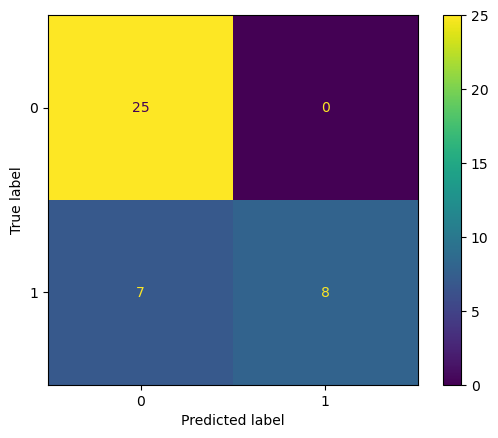

In [69]:
# Confusion Matrix
def generate_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_pred, y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
generate_confusion_matrix(y_test, y_pred)

In [71]:
# Evaluation metrics
def generate_evaluation_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    sensitivity = sensitivity_score(y_test, y_pred)
    specificity = specificity_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f'Accuracy is {accuracy}')
    print(f'F1 score is {f1}')
    print(f'Precision is {precision}')
    print(f'Sensitivity is {sensitivity}')
    print(f'Specificity is {specificity}')
    print(f'ROC AUC is {roc_auc}')
    # This pd series is created for combining the results from all models in the last section
    performance = pd.Series({'Accuracy': accuracy, 'F1': f1, 'Precision': precision, 'Sensitivity': sensitivity,
                             'Specificity': specificity, 'ROC AUC': roc_auc})
    return performance
    
log_reg_performance = generate_evaluation_metrics(y_test, y_pred)

Accuracy is 0.825
F1 score is 0.6956521739130436
Precision is 0.5333333333333333
Sensitivity is 1.0
Specificity is 0.78125
ROC AUC is 0.890625


In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88        32
           1       0.53      1.00      0.70         8

    accuracy                           0.82        40
   macro avg       0.77      0.89      0.79        40
weighted avg       0.91      0.82      0.84        40



In the above `classification report`, only the values in the second row are of interest since `1` is taken to be the positive class. They are exactly the same as their corresponding metrics from the defined function `generate_evaluation_metrics(y_test, y_pred)`.

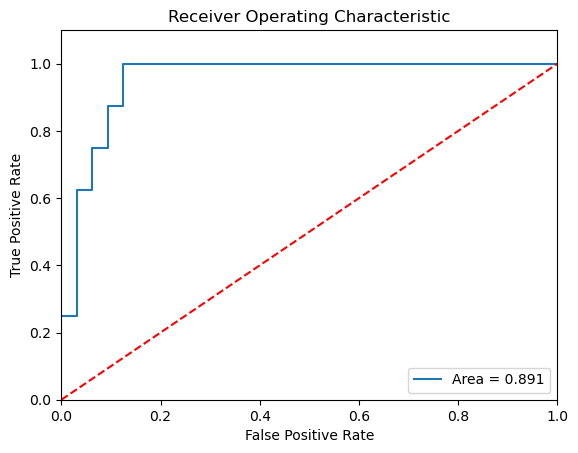

In [74]:
# Plot ROC Curve
def plot_roc_curve(model, y_test, y_pred):
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Area = %0.3f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
plot_roc_curve(log_reg_model, y_test, y_pred)

For `Logistic Regression`, the coefficients of the features in the decision function can be found using the `coef_` attribute. 

In [75]:
# Logistic Regression optimized by GridSearchCV: Find coefficients of predictors
log_reg_feature_coefficients = log_reg_model.best_estimator_.coef_
log_reg_feature_coefficients

array([[ 0.29066574, -0.06229292, -0.09384498, -0.08175389,  0.21819675,
         0.31933453]])

In [76]:
# Match feature coefficients to their respective columns
log_reg_dict = dict(zip(X.columns, list(log_reg_feature_coefficients[0])))
log_reg_dict

{'age': 0.29066573873066154,
 'sysbp': -0.06229292271579075,
 'pulse': -0.09384498349404656,
 'sex': -0.08175389273118346,
 'infection': 0.21819675270365504,
 'emergency': 0.31933452651328686}

Example Interpretation of Feature Coefficients: For every 1 unit increase in `age`, the odds of `Died` increases by $e^{0.29066573873066154}$ times.

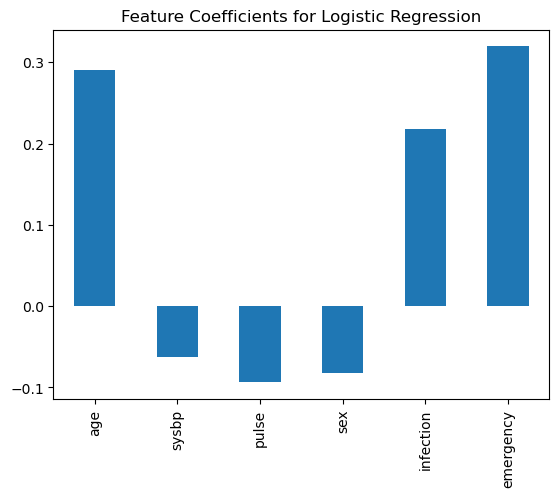

In [77]:
# Visualize feature coefficients for Logistic Regression
log_reg_features_df = pd.DataFrame(log_reg_dict, index=[0])
log_reg_features_df.T.plot.bar(title="Feature Coefficients for Logistic Regression", legend=False);

From the above bar plot, `age`, `infection`, `emergency` have positive correlation with the target variable `survive` while `sysbp`, `pulse`, `sex` have negative correlation with `survive`. The absolute values of the coefficients are much larger for `age`, `infection`, `emergency` compared to the remaining variables, which suggest that they have more significant impact on `survive`.

## Decision Tree

In [78]:
decision_tree = DecisionTreeClassifier(random_state=42)

# Create hyperparameter grid for GridSearchCV
decision_tree_grid = {'max_depth':np.arange(10, 15),
                      'max_features':np.arange(3, 6),
                      'min_samples_split': np.arange(3, 8),
                      'criterion':["gini", "entropy"]}

# Set grid hyperparameter search for Decision Tree
decision_tree_model = GridSearchCV(decision_tree, decision_tree_grid, cv=5, scoring='recall') 

# Fit grid hyperparameter search model on training data
decision_tree_model.fit(X_oversample, y_oversample)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([10, 11, 12, 13, 14]),
                         'max_features': array([3, 4, 5]),
                         'min_samples_split': array([3, 4, 5, 6, 7])},
             scoring='recall')

In [79]:
# Best hyperparameters from GridSearchCV
decision_tree_model.best_params_

{'criterion': 'entropy',
 'max_depth': 13,
 'max_features': 3,
 'min_samples_split': 5}

In [80]:
# Prediction on test set
y_pred = decision_tree_model.predict(X_test)
print(y_pred)

[0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0]


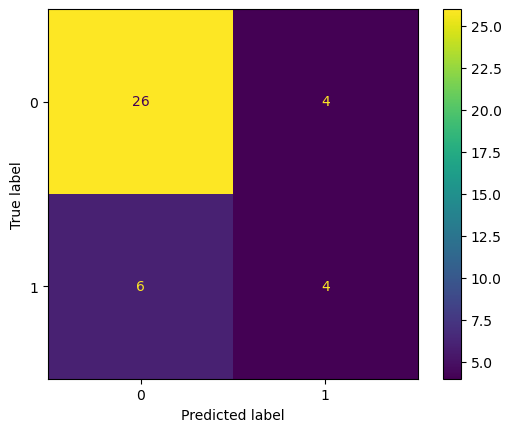

In [81]:
# Confusion Matrix
generate_confusion_matrix(y_test, y_pred)

In [82]:
decision_tree_performance = generate_evaluation_metrics(y_test, y_pred)

Accuracy is 0.75
F1 score is 0.4444444444444445
Precision is 0.4
Sensitivity is 0.5
Specificity is 0.8125
ROC AUC is 0.65625


In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        32
           1       0.40      0.50      0.44         8

    accuracy                           0.75        40
   macro avg       0.63      0.66      0.64        40
weighted avg       0.77      0.75      0.76        40



In the above `classification report`, only the values in the second row are of interest since `1` is taken to be the positive class. They are exactly the same as their corresponding metrics from the defined function `generate_evaluation_metrics(y_test, y_pred)`.

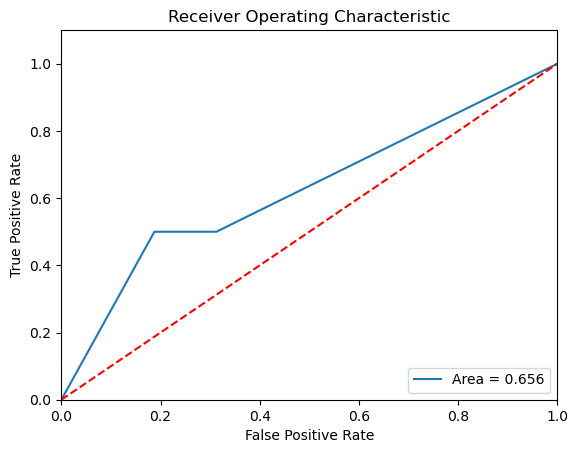

In [83]:
plot_roc_curve(decision_tree_model, y_test, y_pred)

For `Decision Tree`, the importance of the respective features can be found using the `feature_importances_` attribute. 

In [85]:
# Decision Tree optimized by GridSearchCV: Find importance of predictors
dt_feature_importance = list(decision_tree_model.best_estimator_.feature_importances_)
dt_feature_importance

[0.33316554672324583,
 0.2967476215495527,
 0.20299717736600909,
 0.05588525588903969,
 0.03392084646147337,
 0.07728355201067938]

In [86]:
# Match feature importances to their respective columns 
dt_features_dict = dict(zip(X.columns, dt_feature_importance))
dt_features_dict

{'age': 0.33316554672324583,
 'sysbp': 0.2967476215495527,
 'pulse': 0.20299717736600909,
 'sex': 0.05588525588903969,
 'infection': 0.03392084646147337,
 'emergency': 0.07728355201067938}

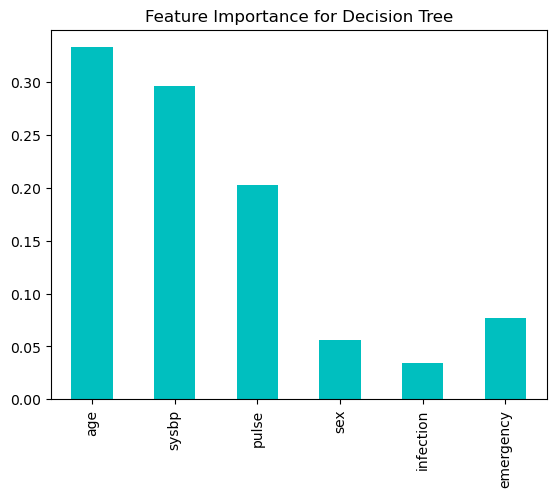

In [87]:
# Visualize feature importance for decision tree
dt_features_df = pd.DataFrame(dt_features_dict, index=[0])
dt_features_df.T.plot.bar(title="Feature Importance for Decision Tree", color='c', legend=False);

From the above bar plot, `age`, `sysbp`, `pulse` are considerably more important in predicting `survive` compared to `sex`, `infection`, `emergency`. `age` is the most important predictor and `infection` is the least important predictor. 

## Random Forest

In [88]:
random_forest = RandomForestClassifier(random_state=42)

# Create hyperparameter grid for GridSearchCV
random_forest_grid = {"n_estimators": np.arange(70, 100, 5),
                      "max_depth": [10, 25, 30],
                      "min_samples_split": np.arange(2, 10, 2),
                      "min_samples_leaf": np.arange(1, 7, 2)}

# Set grid hyperparameter search for Random Forest
random_forest_model = GridSearchCV(random_forest, random_forest_grid, cv=5, scoring='recall') 

# Fit grid hyperparameter search model on training data
random_forest_model.fit(X_oversample, y_oversample)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 25, 30],
                         'min_samples_leaf': array([1, 3, 5]),
                         'min_samples_split': array([2, 4, 6, 8]),
                         'n_estimators': array([70, 75, 80, 85, 90, 95])},
             scoring='recall')

In [89]:
# Best hyperparameters from GridSearchCV
random_forest_model.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 85}

In [90]:
# Prediction on test set
y_pred = random_forest_model.predict(X_test)
print(y_pred)

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0
 0 0 0]


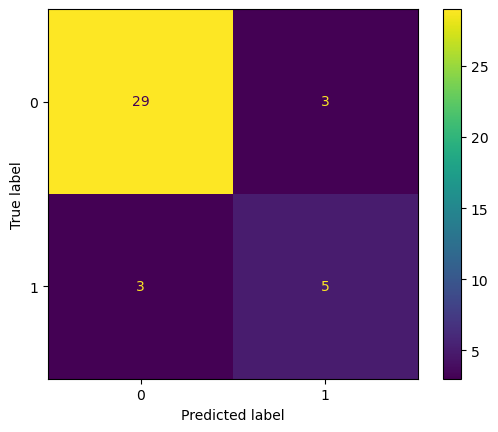

In [91]:
# Confusion Matrix
generate_confusion_matrix(y_test, y_pred)

In [93]:
# Evaluation metrics
random_forest_performance = generate_evaluation_metrics(y_test, y_pred)

Accuracy is 0.85
F1 score is 0.625
Precision is 0.625
Sensitivity is 0.625
Specificity is 0.90625
ROC AUC is 0.765625


In [92]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        32
           1       0.62      0.62      0.62         8

    accuracy                           0.85        40
   macro avg       0.77      0.77      0.77        40
weighted avg       0.85      0.85      0.85        40



In the above `classification report`, only the values in the second row are of interest since `1` is taken to be the positive class. They are exactly the same as their corresponding metrics from the defined function `generate_evaluation_metrics(y_test, y_pred)`.

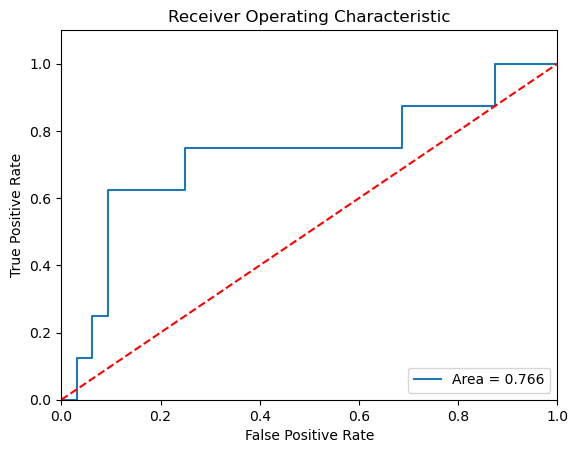

In [94]:
# Plot ROC Curve
plot_roc_curve(random_forest_model, y_test, y_pred)

For `Random Forest`, the importance of the respective features can be found using the `feature_importances_` attribute. 

In [95]:
# Random Forest optimized by GridSearchCV: Find importance of predictors
rf_feature_importance = list(random_forest_model.best_estimator_.feature_importances_)
rf_feature_importance

[0.2873689325576163,
 0.24353523788244097,
 0.2380635479427816,
 0.040474057694610946,
 0.07500706607151149,
 0.11555115785103881]

In [96]:
# Match feature importances to their respective columns 
rf_features_dict = dict(zip(X.columns, rf_feature_importance))
rf_features_dict

{'age': 0.2873689325576163,
 'sysbp': 0.24353523788244097,
 'pulse': 0.2380635479427816,
 'sex': 0.040474057694610946,
 'infection': 0.07500706607151149,
 'emergency': 0.11555115785103881}

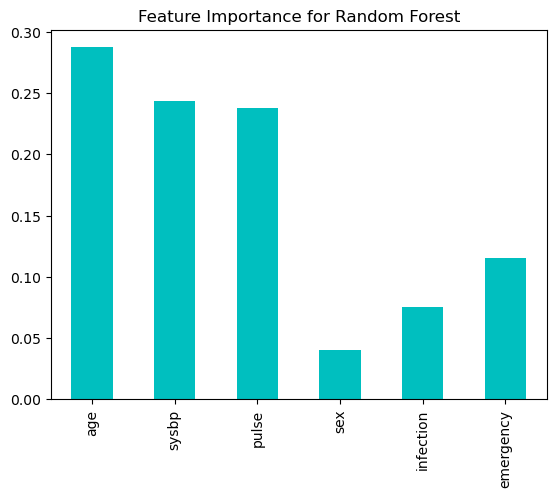

In [97]:
# Visualize feature importance for random forest
rf_features_df = pd.DataFrame(rf_features_dict, index=[0])
rf_features_df.T.plot.bar(title="Feature Importance for Random Forest", color='c', legend=False);

From the above bar plot, `age`, `sysbp`, `pulse` are considerably more important in predicting `survive` compared to `sex`, `infection`, `emergency`. `age` is the most important predictor and `sex` is the least important predictor. 

## Comparison of Models

In [98]:
results_summary = pd.concat([log_reg_performance, decision_tree_performance, random_forest_performance],
                            axis=1).set_axis(['Logistic Regression', 'Decision Tree', 'Random Forest'], axis=1)
results_summary

,Logistic Regression,Decision Tree,Random Forest
Accuracy,0.825000,0.750000,0.850000
F1,0.695652,0.444444,0.625000
Precision,0.533333,0.400000,0.625000
Sensitivity,1.000000,0.500000,0.625000
Specificity,0.781250,0.812500,0.906250
ROC AUC,0.890625,0.656250,0.765625


`Logistic Regression` demonstrates the best performance, exceeding the other models considerably in most evaluation metrics. For instance, the ROC AUC score is the highest for `Logistic Regression`, which suggests that it is better at distinguishing between positive and negative classes compared to the other models. While `Random Forest` slightly outperforms `Logistic Regression` in certain metrics such as Accuracy, `Decision Tree` demonstrates the worst performance among all models. 

In a healthcare setting for ICU patients, the most important objective is to minimise the **False Negative Rate**, i.e. patients in `Died` who are predicted to be in `Survived`. This is to ensure that patients at the highest risk receive timely and adequate treatment to minimise hospital mortality rates. In this context, `Logistic Regression` is the most desirable model because it has the highest sensitivity among all models. In fact, Logistic Regression has a perfect sensitivity score of 1 which indicates that it correctly identifies all patients in the `Died` class. Nevertheless, it is important to note that the testing data has a limited size of 40 observations with only 8 of them in the `Died` class. A larger dataset would be necessary for more reliable and rigorous results.